# Lesson 5 // Sentiment analysis

---

Sentiment analysis is the study of the emotional content of a body of text. When we read text, as humans, we infer the emotional content from the words used in the text, and some more subtle cues involving how these words are put together. Sentiment analysis tries to do the same thing algorithmically. 

One way of approaching the problem is to assess the sentiment of individual words, and then aggregate the sentiments of the words in a body of text in some way. For example, if we can classify whether each word is positive, negative, or neutral, we can count up the number of positive, negative, and neutral words in the document and define that as the sentiment of the document. This is just one way - a particularly simple way - of doing document-level sentiment analysis. 

When assessing the sentiment or emotional content of individual words, we usually make use of existing sentiment dictionaries (or "lexicons") that have already done this using some kind of manual classification. 

This notebook is an introduction to sentiment analysis, in which we will:

1. Introduce the sentiment lexicons that come with **tidytext**.
2. Look at how to aggregate sentiments over words to assess the sentiment of a longer sequence of text, like a tweet.
3. See how to handle "negation" words like "not" that reverse the sentiment of the word that follows it - for example "not good".
4. Use all of the above to analyze the emotional content of Donald Trump's tweets and examine how these have changed over time.

[Chapter 2](tidytextmining.com/sentiment.html) of TMR covers sentiment analysis, and negation is handled in [Chapter 4](http://tidytextmining.com/ngrams.html#tokenizing-by-n-gram). Many of the ideas and some of the code in this workbook are drawn from these chapters. 

---

First load the packages we need for this lesson:

In [2]:
library(tidyverse)
library(tidytext)
library(stringr)
library(lubridate)

options(repr.plot.width=4, repr.plot.height=3) # set plot size in the notebook

Loading tidyverse: ggplot2
Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Loading tidyverse: dplyr
Conflicts with tidy packages ---------------------------------------------------
filter(): dplyr, stats
lag():    dplyr, stats

Attaching package: 'lubridate'

The following object is masked from 'package:base':

    date



Next, we load the .RData file containing the tweets and get the data into tidy text format. These are the same operations we did in the previous notebook, so go back to that notebook if you need more details about what is happening below.

In [5]:
load("data/trump-tweets.RData")

# make data a tibble
tweets <- as.tibble(tweets)

# parse the date and add some date related variables
tweets <- tweets %>% 
  mutate(date = parse_datetime(str_sub(tweets$created_at,5,30), "%b %d %H:%M:%S %z %Y")) %>% 
  mutate(is_prez = (date > ymd(20161108))) %>%
  mutate(month = make_date(year(date), month(date)))

# turn into tidy text 
replace_reg <- "https://t.co/[A-Za-z\\d]+|http://[A-Za-z\\d]+|&amp;|&lt;|&gt;|RT|https"
unnest_reg <- "([^A-Za-z_\\d#@']|'(?![A-Za-z_\\d#@]))"
tidy_tweets <- tweets %>% 
  filter(!str_detect(text, "^RT")) %>% # remove retweets
  mutate(text = str_replace_all(text, replace_reg, "")) %>% # remove stuff we don't want like links
  unnest_tokens(word, text, token = "regex", pattern = unnest_reg) %>% # tokenize
  filter(!word %in% stop_words$word, str_detect(word, "[a-z]")) %>% # remove stop words
  select(date,word,is_prez,favorite_count,id_str,month) # choose the variables we need

In [6]:
#load("data/trump-tweets.RData")
#tweets

tidy_tweets

date,word,is_prez,favorite_count,id_str,month
2012-10-23 21:10:21,media,FALSE,160,260850671576829952,2012-10-01
2012-10-23 21:10:21,event,FALSE,160,260850671576829952,2012-10-01
2012-10-23 21:10:21,donald,FALSE,160,260850671576829952,2012-10-01
2012-10-23 21:10:21,trump,FALSE,160,260850671576829952,2012-10-01
2012-10-23 21:10:21,united,FALSE,160,260850671576829952,2012-10-01
2012-10-23 21:10:21,america,FALSE,160,260850671576829952,2012-10-01
2012-10-23 21:10:21,rxtnzi1o,FALSE,160,260850671576829952,2012-10-01
2012-10-24 16:15:36,stated,FALSE,654,261138885466267648,2012-10-01
2012-10-24 16:15:36,press,FALSE,654,261138885466267648,2012-10-01
2012-10-24 16:15:36,release,FALSE,654,261138885466267648,2012-10-01


## Using sentiment lexicons

The **tidytext** package comes with a three existing sentiment lexicons or dictionaries. These describe the emotional content of individual words in different formats, and have been put together manually.

* *afinn*: a list of words given a positivity score between minus five (negative) and plus five (positive). The words have been manually labelled by Finn Arup Nielsen. See [here](https://finnaarupnielsen.wordpress.com/2011/03/16/afinn-a-new-word-list-for-sentiment-analysis/) and [here](http://www2.imm.dtu.dk/pubdb/views/publication_details.php?id=6010) for more details.
* *bing*: a sentiment lexicon created by Bing Liu and collaborators. A list of words are labelled as "positive" or "negative". More details [here](https://www.cs.uic.edu/~liub/FBS/sentiment-analysis.html).
* *nrc*: a sentiment lexicon put together by Saif Mohammad and Peter Turney using crowdsourcing on Amazon Mechanical Turk. Words are labelled as "positive" or "negative", but also as "anger", "anticipation", "disgust", "fear", "joy", "sadness", "surprise", or "trust". A word can receive multiple labels. More details [here](http://saifmohammad.com/WebPages/lexicons.html).

In [4]:
get_sentiments("afinn") %>% head(10)
get_sentiments("bing") %>% head(10)
get_sentiments("nrc") %>% head(10)

word,score
abandon,-2
abandoned,-2
abandons,-2
abducted,-2
abduction,-2
abductions,-2
abhor,-3
abhorred,-3
abhorrent,-3
abhors,-3


word,sentiment
2-faced,negative
2-faces,negative
a+,positive
abnormal,negative
abolish,negative
abominable,negative
abominably,negative
abominate,negative
abomination,negative
abort,negative


word,sentiment
abacus,trust
abandon,fear
abandon,negative
abandon,sadness
abandoned,anger
abandoned,fear
abandoned,negative
abandoned,sadness
abandonment,anger
abandonment,fear


Below we use the *bing* lexicon to add a new variable indicating whether each word in our `tidy_tweets` data frame is positive or negative. We use a left join here, which keeps *all* the words in `tidy_tweets`. Words appearing in our tweets but not in the *bing* lexicon will appear as `NA`. We rename these "neutral", but need to be a bit careful here. No sentiment lexicon contains all words, so some words that are *actually* positive or negative will be labelled as `NA` and hence "neutral". We can avoid this problem by using an inner join rather than a left join, by filtering out neutral words later on, or by just keeping in mind that "neutral" doesn't really mean "neutral".

There's one last issue: in the *bing* lexicon the word "trump" is positive, which will obviously skew the sentiment of Trump's tweets, particularly bearing in mind he often tweets about himself! We (rather generously I think) manually recode the sentiment of this word to "neutral".

In [5]:
tidy_tweets <- tidy_tweets %>% 
  left_join(get_sentiments("bing")) %>% # add sentiments (pos or neg)
  select(word,sentiment,everything()) %>%
  mutate(sentiment = ifelse(word == "trump", NA, sentiment)) %>% # "trump" is a positive word in the bing lexicon!
  mutate(sentiment = ifelse(is.na(sentiment), "neutral", sentiment))

Joining, by = "word"


Let's look at Trump's 20 most common positive words:

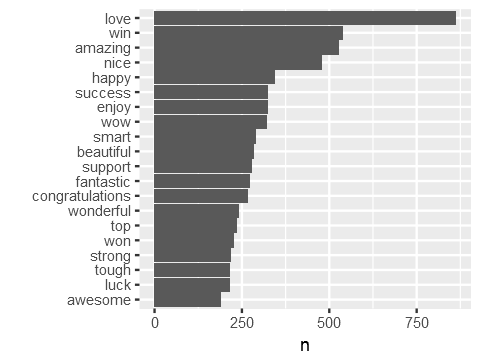

In [6]:
tidy_tweets %>%
  filter(sentiment == "positive") %>%
  count(word) %>%
  arrange(desc(n)) %>%
  filter(rank(desc(n)) <= 20) %>%
  ggplot(aes(reorder(word,n),n)) + geom_col() + coord_flip() + xlab("")

and the 20 most common negative words:

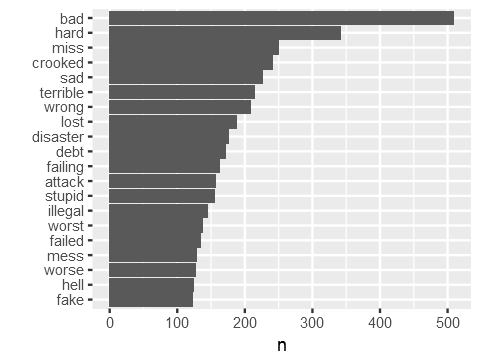

In [7]:
tidy_tweets %>%
  filter(sentiment == "negative") %>%
  count(word) %>%
  arrange(desc(n)) %>%
  filter(rank(desc(n)) <= 20) %>%
  ggplot(aes(reorder(word,n),n)) + geom_col() + coord_flip() + xlab("")

## Changes in sentiment over time

Once we have attached sentiments to words in our data frame, we can analyze these in various ways. For example, we can examine trends in sentiment over time. Here we count the number of positive, negative and neutral words used each month and plot these. Because the neutral words dominate, its difficult to see any trends with them included (try this and see for yourself). We therefore remove the neutral words before plotting.

In [8]:
sentiments_per_month <- tidy_tweets %>%
  group_by(month, sentiment) %>%
  summarize(n = n()) 

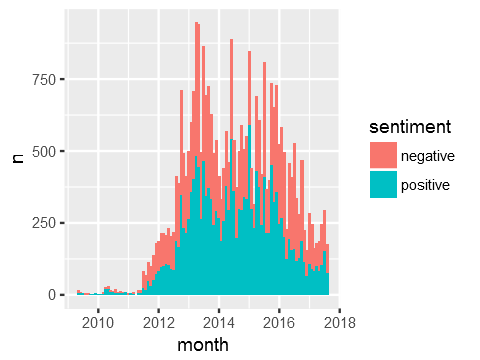

In [9]:
ggplot(filter(sentiments_per_month, sentiment != "neutral"), aes(x = month, y = n, fill = sentiment)) +
  geom_col() 

There doesn't seem to be any very clear trend here, but the variation in the number of tweets made each month makes it difficult to see. We can improve the visualization by plotting the *proportion* of all words tweeted in a month that were positive or negative. The plot shows the raw proportions as well as smoothed versions of these. 

In [10]:
sentiments_per_month <- sentiments_per_month %>% 
  left_join(sentiments_per_month %>% 
            group_by(month) %>% 
            summarise(total = sum(n))) %>%
  mutate(freq = n/total) 

Joining, by = "month"


`geom_smooth()` using method = 'loess'


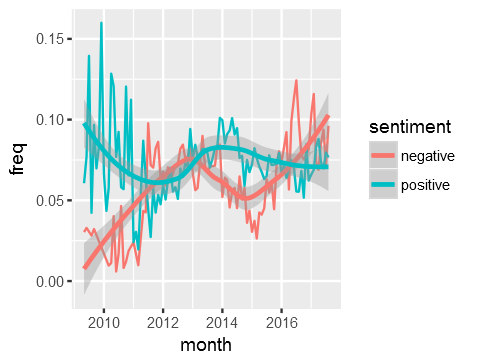

In [11]:
sentiments_per_month %>% filter(sentiment != "neutral") %>%
  ggplot(aes(x = month, y = freq, colour = sentiment)) +
  geom_line() + 
  geom_smooth(aes(colour = sentiment))

We can fit a simple linear model to check with the proportion of negative words has increased over time. Strictly speaking the linear model is not appropriate as the response is bounded to lie between 0 and 1 - you could try fitting e.g. a binomial GLM instead.

In [12]:
model <- lm(freq ~ month, data = subset(sentiments_per_month, sentiment == "negative"))
summary(model)


Call:
lm(formula = freq ~ month, data = subset(sentiments_per_month, 
    sentiment == "negative"))

Residuals:
      Min        1Q    Median        3Q       Max 
-0.044389 -0.016194 -0.000743  0.016303  0.050656 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -2.202e-01  4.301e-02  -5.119 1.76e-06 ***
month        1.764e-05  2.687e-06   6.565 3.37e-09 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.02137 on 89 degrees of freedom
Multiple R-squared:  0.3263,	Adjusted R-squared:  0.3187 
F-statistic:  43.1 on 1 and 89 DF,  p-value: 3.373e-09


## Aggregating sentiment over words

So far we've looked at the sentiment of individual words. How can we assess the sentiment of longer sequences of text, like bigrams, sentences or entire tweets. One approach is to attach sentiments to each word in the longer sequence, and then add up the sentiments over words. This isn't the only way, but it is relatively easy to do and fits in nicely with the use of tidy text data. 

Suppose we want to analyze the sentiment of entire tweets. We'll measure the positivity of a tweet by the difference in the number of positive and negative words used in the tweet.

In [13]:
sentiments_per_tweet <- tidy_tweets %>%
  group_by(id_str) %>%
  summarize(net_sentiment = (sum(sentiment == "positive") - sum(sentiment == "negative")),
            month = first(month))

To see if the measure makes sense, let's have a look at the most negative tweets.

In [14]:
tweets %>% 
    left_join(sentiments_per_tweet) %>% 
    arrange(net_sentiment) %>% 
    head(10) %>%
    select(text, net_sentiment) 

Joining, by = c("id_str", "month")


text,net_sentiment
"How come every time I show anger, disgust or impatience, enemies say I had a tantrum or meltdown—stupid or dishonest people?",-8
"Hillary said ""I really deplore the tone and inflammatory rhetoric of his campaign."" I deplore the death and destruction she caused-stupidity",-7
The Fake News Media has never been so wrong or so dirty. Purposely incorrect stories and phony sources to meet their agenda of hate. Sad!,-7
".@BarackObama is promoting ugly, inefficient, unreliable, bird-killing, noisy, neighborhood-destroying wind turbines. Big mistake.",-6
"""@bx_bobby: @realDonaldTrump what was racist about that story?"" The story wasn't racist, just inaccurate and wrong. Bryant is dumb &amp; racist",-6
I've just started blocking out some of the repetitive and boring (&amp; dumb) haters and losers. They are a waste of time and energy!,-6
Really bad article about me in the dying (or dead) Esquire Magazine. Totally false - lots of hatred. When will this boring magazine close?,-6
“I'm not afraid of failing. I don't like to fail. I hate to fail. But I'm not afraid of it.” - @VinceMcMahon,-6
"The virtually incompetent Republican Strategist who has had a failed career, Cheri Jacobus, is incoherent with anger that her puppets died!",-6
.@KarlRove is a biased dope who wrote falsely about me re China and TPP. This moron wasted $430 million on political campaigns and lost 100%,-6


And the most positive tweets:

In [15]:
tweets %>% 
  left_join(sentiments_per_tweet) %>% 
  arrange(desc(net_sentiment)) %>% 
    head(10) %>%
  select(text, net_sentiment) 

Joining, by = c("id_str", "month")


text,net_sentiment
"""@HHShkMohd: To all people in the UAE: your support and enthusiasm fuelled our victory at Dubai #Expo2020. Congratulations, a fantastic win!",6
"""Success is not the key to happiness. Happiness is the key to success. If you love what you are doing, you'll be a success."" - A. Schweitzer",6
"Be tenacious. Being tenacious means you're tough and patient at once, so it's a formidable combination.",5
Happy to hear that @ralphreed's Faith and Freedom chapters are at the @RNC convention supporting @MittRomney. We must be united to win!,5
"Work is fun, deals are fun, life is fun - but love of a great family makes it all come together. Go out there and make your family proud.",5
"Winner of the 5 Star Diamond Award, @TrumpGolfLA brings luxury &amp; elite amenities to LA's top public golf course http://t.co/MYiwkyfiVU",5
"“Build confidence starting with small successes that lead to greater and greater successes--there is nothing like winning."" -Think Big",5
Negotiation tip: Be reasonable &amp; flexible. Being open to change could lead you into a fortunate situation and open the door to innovation.,5
"""@barnard_sonja: @realDonaldTrump I wish I had your confidence!"" WIN, WIN, WIN and you will develop great confidence!",5
"""Remember that things are cyclical, so be resilient, be patient, be creative, and remain positive."" - Think Like a Champion",5


We can also look at trends over time. The plot below shows the proportion of monthly tweets that were negative (i.e. where the number of negative words exceeded the number of positive ones).

`geom_smooth()` using method = 'loess'


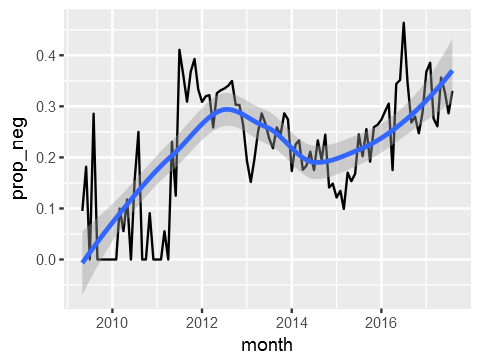

In [16]:
sentiments_per_tweet %>%
  group_by(month) %>%
  summarize(prop_neg = sum(net_sentiment < 0) / n()) %>%
  ggplot(aes(x = month, y = prop_neg)) +
  geom_line() + geom_smooth()

 ## Dealing with negation
 
One problem we haven't considered yet is what to do with terms like "not good", where a positive word is negated by the use of "not" before it. We need to reverse the sentiment of words that are preceded by negation words like not, never, *etc*.
 
We'll do this in the context of a sentiment analysis on bigrams. We start by creating the bigrams, and separating the two words making up each bigram. This is the same code used in the previous notebook.

In [17]:
bigrams_separated  <- tweets %>%
  filter(!str_detect(text, "^RT")) %>%
  mutate(text = str_replace_all(text, replace_reg, "")) %>%
  unnest_tokens(bigram, text, token = "ngrams", n = 2) %>%
  separate(bigram, c("word1", "word2"), sep = " ")

Then we use the *bing* sentiment dictionary to look up the sentiment of each word in each bigram. 

In [18]:
bigrams_separated <- bigrams_separated %>% 
    # add sentiment for word 1
    left_join(get_sentiments("bing"), by = c(word1 = "word")) %>%
    rename(sentiment1 = sentiment) %>%
    mutate(sentiment1 = ifelse(word1 == "trump", NA, sentiment1)) %>%
    mutate(sentiment1 = ifelse(is.na(sentiment1), "neutral", sentiment1)) %>%
    
    # add sentiment for word 1
    left_join(get_sentiments("bing"), by = c(word2 = "word")) %>%
    rename(sentiment2 = sentiment) %>%
    mutate(sentiment2 = ifelse(word2 == "trump", NA, sentiment2)) %>%
    mutate(sentiment2 = ifelse(is.na(sentiment2), "neutral", sentiment2)) %>%
    select(month,word1,word2,sentiment1,sentiment2,everything())

Now we need a list of words that we consider to be negation words. I'll use the following set, taken from TMR [Chapter 4](http://tidytextmining.com/ngrams.html), and show a few examples.

In [19]:
negation_words <- c("not", "no", "never", "without")

# show a few
filter(bigrams_separated, word1 %in% negation_words) %>% 
    head(10) %>% select(month, word1, word2, sentiment1, sentiment2) # for display purposes

month,word1,word2,sentiment1,sentiment2
2012-10-01,not,a,neutral,neutral
2012-10-01,no,check,neutral,neutral
2012-10-01,never,properly,neutral,positive
2012-11-01,not,show,neutral,neutral
2012-11-01,no,talent,neutral,positive
2012-11-01,no,persona,neutral,neutral
2013-02-01,no,longer,neutral,neutral
2013-02-01,no,money,neutral,neutral
2013-02-01,no,comparison,neutral,neutral
2013-03-01,not,going,neutral,neutral


We now reverse the sentiment of `word2` whenever it is preceded by a negation word, and then add up the number of positive and negative words within a bigram and take the difference. That difference (a score from -2 to +2) is the sentiment of the bigram.

We do this in two steps for illustrative purposes. First we reverse the sentiment of the second word in the bigram if the first one is a negation word. 

In [20]:
bigrams_separated <- bigrams_separated %>%

    # create a variable that is the opposite of sentiment2
    mutate(opp_sentiment2 = recode(sentiment2, "positive" = "negative",
                                 "negative" = "positive",
                                 "neutral" = "neutral")) %>%
    
    # reverse sentiment2 if word1 is a negation word
    mutate(sentiment2 = ifelse(word1 %in% negation_words, opp_sentiment2, sentiment2)) %>%
    
    # remove the opposite sentiment variable, which we don't need any more
    select(-opp_sentiment2)

Next, we calculate the sentiment of each bigram and join up the words in the bigram again.

In [21]:
bigrams_separated <- bigrams_separated %>%
  mutate(net_sentiment = (sentiment1 == "positive") + (sentiment2 == "positive") - 
              (sentiment1 == "negative") - (sentiment2 == "negative")) %>%
  unite(bigram, word1, word2, sep = " ", remove = FALSE)

Below we show Trump's most common positive and negative bigrams. 

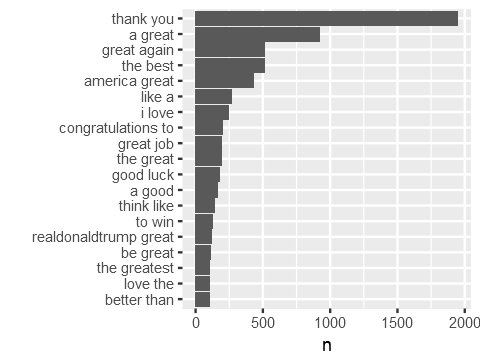

In [22]:
bigrams_separated %>%
  filter(net_sentiment > 0) %>% # get positive bigrams
  count(bigram, sort = TRUE) %>%
  filter(rank(desc(n)) < 20) %>%
  ggplot(aes(reorder(bigram,n),n)) + geom_col() + coord_flip() + xlab("")

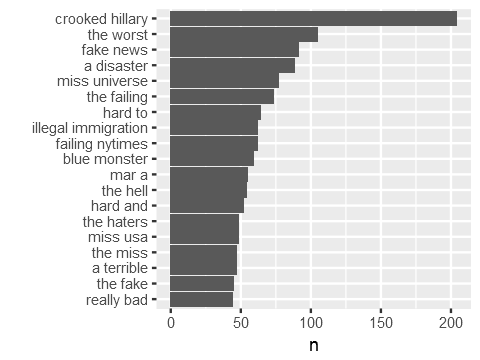

In [23]:
bigrams_separated %>%
  filter(net_sentiment < 0) %>% # get negative bigrams
  count(bigram, sort = TRUE) %>%
  filter(rank(desc(n)) < 20) %>%
  ggplot(aes(reorder(bigram,n),n)) + geom_col() + coord_flip() + xlab("")

None of the most common negative bigrams have negated words in them but some that are slightly less frequently used do. Notice that the most frequently used bigram below is "no wonder" - which is not really negative, although you can see how, using the approach we have, it has ended up classified as such. Cases like these would need to be handled on an individual basis.

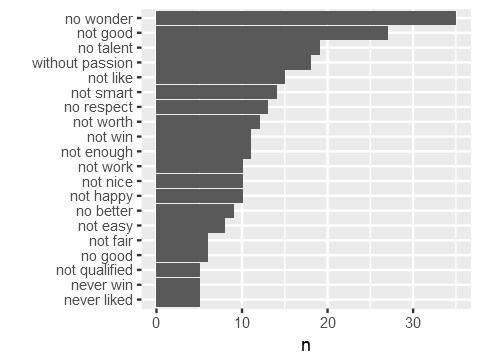

In [24]:
bigrams_separated %>%
    filter(net_sentiment < 0) %>% # get negative bigrams
    filter(word1 %in% negation_words) %>% # get bigrams where first word is negation
    count(bigram, sort = TRUE) %>%
    filter(rank(desc(n)) < 20) %>%
    ggplot(aes(reorder(bigram,n),n)) + geom_col() + coord_flip() + xlab("")

## Exercises

1. Adverbs like "very", "extremely", "totally", "really", "quite", "marginally", *etc* increase or decrease the magnitude of the sentiment that follows them. Think of a few qualifiers and build these into the analyses above. What are they most positive and negative tweets once these qualifiers have been added? Does it affect the assessment of whether the sentiment of Trump's tweets has changed over time?
2. Is there a relationship between the sentiment of a tweet and its popularity? Are negative tweets less popular than positive ones?
3. Is there a "day of the week" effect on the number and sentiment of tweets? Are weekends any different to weekdays?
4. Use the more nuanced *nrc* lexicon, which categorises words as "anger", "fear", *etc* to re-analyse Trump's tweets. Can you pick up anything interesting?
5. Note the appearance of the bigrams "miss usa" and "miss universe" in the plot of most common negative bigrams in the notebook. This is a clear misinterpretation of "miss". How might you remove the ambiguity in these kinds of bigrams in a general way (either just think of a way or, better, implement it!)